In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# damped exponential smoothing random walk
def generate_random_walk(n):
    alpha = 0.75
    beta = 0.5
    phi = 0.9
    
    l = 0.0
    b = 0.0
    
    y = 0.0
    
    walk = []
    
    while len(walk) < n:
        eps = 0.1*np.random.randn()
        y = l + phi*b + eps
        l = l + phi*b + alpha*eps
        b = phi*b + alpha*beta*eps
        walk.append(y)
    
    return np.array(walk)

In [3]:
walk = generate_random_walk(2000)

walk = (walk - walk.mean()) / walk.std()

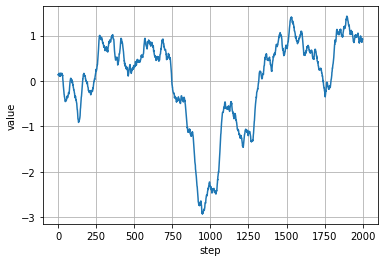

In [4]:
# Plot the target curve (a sanity check)
fig, ax = plt.subplots()

ax.plot(walk)

ax.grid()
ax.set_xlabel("step")
ax.set_ylabel("value")

plt.show()

In [5]:
class ModelRNN(nn.Module):
    
    def __init__(self, input_size, hidden_size):
        super().__init__()
        
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size)
        self.dense = nn.Sequential(
            nn.Linear(hidden_size, 128), 
            nn.ReLU(), 
            nn.Linear(128, 128), 
            nn.ReLU(), 
            nn.Linear(128, 1))
    
    def forward(self, x, h=None):
        if h is None:
            h = torch.zeros(1, x.shape[0], self.hidden_size)
        
        x = torch.unsqueeze(x, 0)
        x, h = self.rnn(x, h)
        x = torch.squeeze(x, 0)
        x = self.dense(x)
        
        return x, h

In [6]:
x = torch.tensor(walk, dtype=torch.float32).view(-1, 1)

In [7]:
model = ModelRNN(1, 24)

In [8]:
optimizer = optim.Adam(model.parameters())

In [9]:
losses = []

for _ in range(0, 100):
    model.train()
    optimizer.zero_grad()
    
    i0 = np.random.randint(0, x.shape[0] - 201, 128)
    
    x_hat, h = model(x[i0])
    loss = ((x_hat - x[i0 + 1])**2).mean()
    
    for k in range(1,200):
        x_hat, h = model(x[i0 + k], h)
        loss += ((x_hat - x[i0 + k + 1])**2).mean()
    
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())

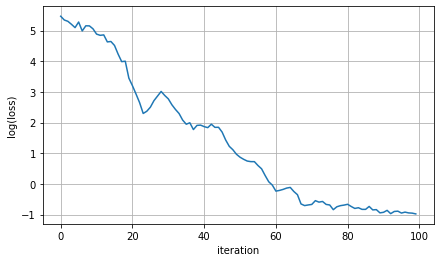

In [10]:
fig, ax = plt.subplots(figsize=(7, 4))

ax.plot(np.log(losses))
ax.grid()

ax.set_xlabel("iteration")
ax.set_ylabel("log(loss)")

plt.show()

In [11]:
preds = []

h = None

for i in range(0, len(walk)):
    x_hat, h = model(x[i:i+1])
    preds.append(x_hat.item())

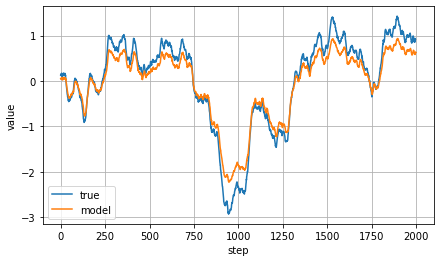

In [13]:
# Plot the target curve (a sanity check)
fig, ax = plt.subplots(figsize=(7, 4))

ax.plot(walk[2:], label="true")
ax.plot(preds, label="model")

ax.grid()
ax.set_xlabel("step")
ax.set_ylabel("value")
ax.legend()

plt.show()